# **Data Visualisation**

## Objectives

*  Answer business requirement 1: 
    * The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

## Inputs

* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/validation

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* No Comments



---

# Set working directory and Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/mildew-detector')
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detector'

# Set input directories

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

# Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


# Set label names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Visualize image Data

Image shape

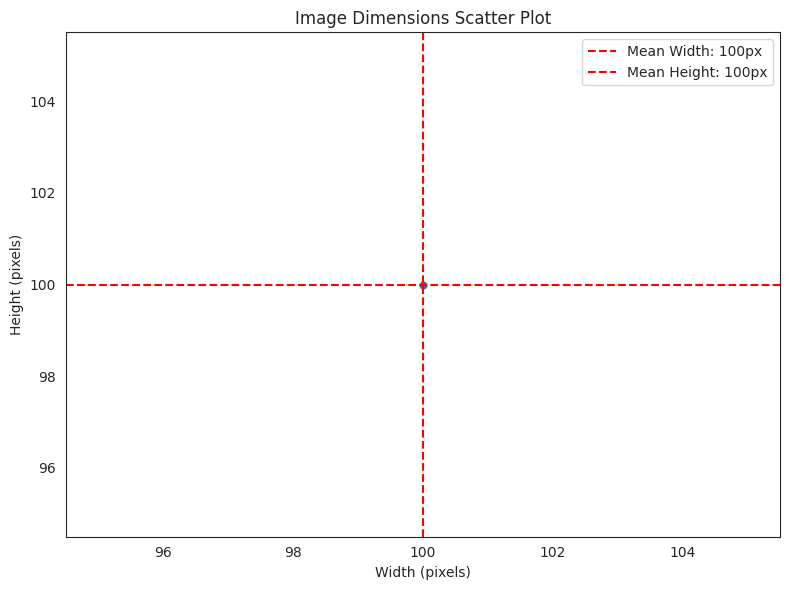

Mean Width: 100 pixels
Mean Height: 100 pixels


In [8]:

# Initialize lists to store image dimensions
dim1, dim2 = [], []

# Loop through each label and image in the dataset
for label in labels:
    for image_filename in os.listdir(os.path.join(train_path, label)):
        image_path = os.path.join(train_path, label, image_filename)
        
        try:
            # Read the image and extract dimensions
            img = imread(image_path)
            d1, d2, _ = img.shape
            dim1.append(d1)  # Image height
            dim2.append(d2)  # Image width
        
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# Calculate mean dimensions
dim1_mean = int(np.mean(dim1))
dim2_mean = int(np.mean(dim2))

# Plot image dimensions
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(x=dim2, y=dim1, alpha=0.2, ax=ax)
ax.set_xlabel("Width (pixels)")
ax.set_ylabel("Height (pixels)")
ax.set_title("Image Dimensions Scatter Plot")

# Add mean lines
ax.axvline(x=dim2_mean, color='r', linestyle='--', label=f"Mean Width: {dim2_mean}px")
ax.axhline(y=dim1_mean, color='r', linestyle='--', label=f"Mean Height: {dim1_mean}px")

# Add legend and display plot
ax.legend()
plt.tight_layout()
plt.show()

# Print mean dimensions
print(f"Mean Width: {dim2_mean} pixels")
print(f"Mean Height: {dim1_mean} pixels")

Change image shape to 100 x 100

In [18]:
from PIL import Image

# Target dimensions
target_size = (100, 100)

# Resize images
for label in labels:
    label_path = os.path.join(train_path, label)
    for image_filename in os.listdir(label_path):
        image_path = os.path.join(label_path, image_filename)
        
        try:
            # Read and resize image
            img = imread(image_path)
            img_resized = Image.fromarray(img).resize(target_size)
            
            # Overwrite the original image
            img_resized.save(image_path)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

Image size for training the model

In [9]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(100, 100, 3)

Save the image shape

In [21]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

Function to load images in an array

In [17]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

Load image shapes and labels in an array

In [18]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 100, 100, 3) (60,)


Plot and save mean and variability of images per label

In [19]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False, file_path=''):
    """
    Plot the mean and variability of images per label.

    Parameters:
        X (numpy.ndarray): The images array of shape (n_samples, height, width, channels).
        y (numpy.ndarray): The labels array of shape (n_samples,).
        figsize (tuple): The size of the plot (default is (12, 5)).
        save_image (bool): Whether to save the image (default is False).
        file_path (str): Path to save the image if save_image is True (default is '').
    """
    
    sns.set_style("white")

    for label_to_display in np.unique(y):
        print(f"==== Label {label_to_display} ====")
        
        # Subset the images belonging to the current label
        label_mask = y == label_to_display
        selected_images = X[label_mask]
        
        # Calculate the average and standard deviation images
        avg_img = np.mean(selected_images, axis=0)
        std_img = np.std(selected_images, axis=0)
        
        print(f"Image Shape: {avg_img.shape}")
        
        # Create the figure and axes
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Plot the average image
        axes[0].imshow(avg_img)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].axis('off')
        
        # Plot the variability image
        axes[1].imshow(std_img)
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].axis('off')
        
        # Save the image or show it
        if save_image:
            if file_path:
                plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
            else:
                print("No file path provided. Not saving image.")
        else:
            plt.tight_layout()
            plt.show()

        print("\n")

==== Label healthy ====
Image Shape: (100, 100, 3)


==== Label powdery_mildew ====
Image Shape: (100, 100, 3)




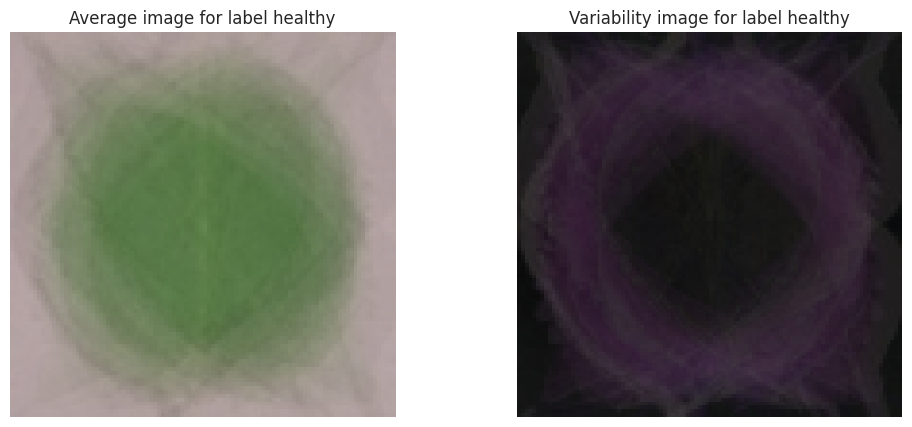

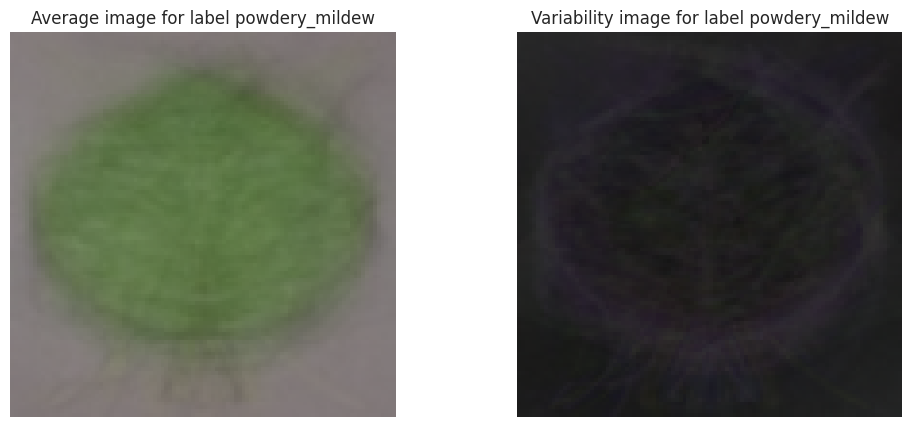

In [21]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True, file_path='outputs')

Difference between average healty and average powdery mildew leaf images

In [38]:
def subset_image_label(X, y, label_to_display):
    """
    Filters the images corresponding to the given label.
    
    Parameters:
        X (numpy.ndarray): Array of images.
        y (numpy.ndarray): Array of labels.
        label_to_display (int or str): The label to filter images by.

    Returns:
        numpy.ndarray: Array of images belonging to the given label.
    """
    mask = (y == label_to_display)
    return X[mask]

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False, file_path=''):
    """
    Compares the average images for two labels and plots the differences.

    Parameters:
        X (numpy.ndarray): Array of images.
        y (numpy.ndarray): Array of labels.
        label_1 (int or str): First label for comparison.
        label_2 (int or str): Second label for comparison.
        figsize (tuple): Figure size for the plot.
        save_image (bool): Whether to save the plot or not.
        file_path (str): Path to save the plot if `save_image` is True.

    Returns:
        None
    """
    sns.set_style("white")

    # Check if both labels exist in the dataset
    unique_labels = np.unique(y)
    if label_1 not in unique_labels or label_2 not in unique_labels:
        print(f"Error: One or both labels ({label_1}, {label_2}) are not in {unique_labels}.")
        return

    # Get images corresponding to label_1 and label_2
    label1_images = subset_image_label(X, y, label_1)
    label2_images = subset_image_label(X, y, label_2)

    # Calculate the average images for both labels
    label1_avg = np.mean(label1_images, axis=0)
    label2_avg = np.mean(label2_images, axis=0)

    # Calculate the difference between the average images
    diff_avg = label1_avg - label2_avg

    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[0].axis('off')
    
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[1].axis('off')
    
    axes[2].imshow(diff_avg, cmap='gray')
    axes[2].set_title(f'Difference (Avg {label_1} - Avg {label_2})')
    axes[2].axis('off')

    # Save or display the plot
    if save_image:
        if file_path:
            plt.savefig(f"{file_path}/avg_diff_{label_1}_{label_2}.png", bbox_inches='tight', dpi=150)
        else:
            print("No file path provided, image will not be saved.")
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


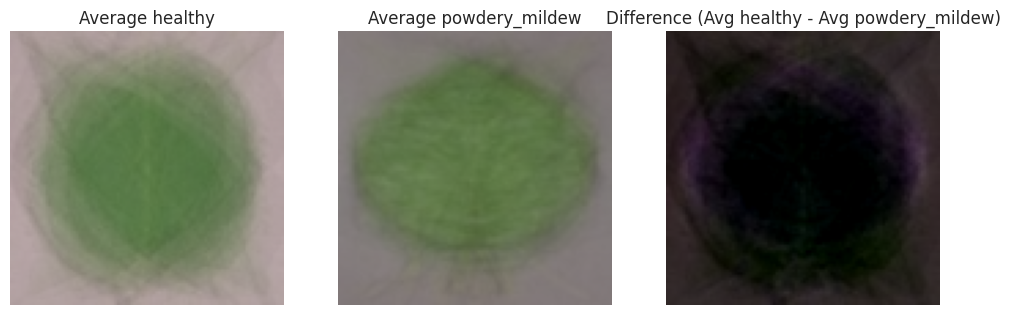

In [40]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True,
                                        file_path="outputs"
                                        )


# Image Montage

In [8]:
import itertools
import random
sns.set_style("white")

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    Displays a montage of images from a specified directory and label.
    
    Parameters:
    - dir_path (str): Path to the main directory containing labeled folders of images.
    - label_to_display (str): Subfolder name inside the directory containing images to display.
    - nrows (int): Number of rows in the montage grid.
    - ncols (int): Number of columns in the montage grid.
    - figsize (tuple): Size of the figure (default is (15, 10)).
    """
    
    # Check if the directory exists
    if not os.path.isdir(dir_path):
        print(f"Directory not found: {dir_path}")
        return

    # List available labels (subdirectories)
    labels = os.listdir(dir_path)
    
    # Check if the specified label exists
    if label_to_display not in labels:
        print(f"The label '{label_to_display}' doesn't exist.")
        print(f"Available labels: {labels}")
        return

    # Get the list of images in the specified label directory
    label_path = os.path.join(dir_path, label_to_display)
    images_list = os.listdir(label_path)

    # Check if the montage grid can accommodate the images
    if nrows * ncols > len(images_list):
        print(
            f"Montage grid is too large for the available images.\n"
            f"Number of images available: {len(images_list)}\n"
            f"Requested grid size: {nrows * ncols} (nrows={nrows}, ncols={ncols})"
        )
        return

    # Randomly sample images to fit the grid size
    img_idx = random.sample(images_list, nrows * ncols)

    # Prepare the grid of axes
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    plot_idx = list(itertools.product(range(nrows), range(ncols)))

    # Loop through the sampled images and plot them
    for i, img_name in enumerate(img_idx):
        img_path = os.path.join(label_path, img_name)
        img = imread(img_path)
        img_shape = img.shape
        
        # Get the row and column indices for the current plot
        row, col = plot_idx[i]
        
        # Display the image
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"{img_shape[1]}px x {img_shape[0]}px")
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

    # Hide any unused subplots
    for i in range(len(img_idx), nrows * ncols):
        row, col = plot_idx[i]
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

healthy


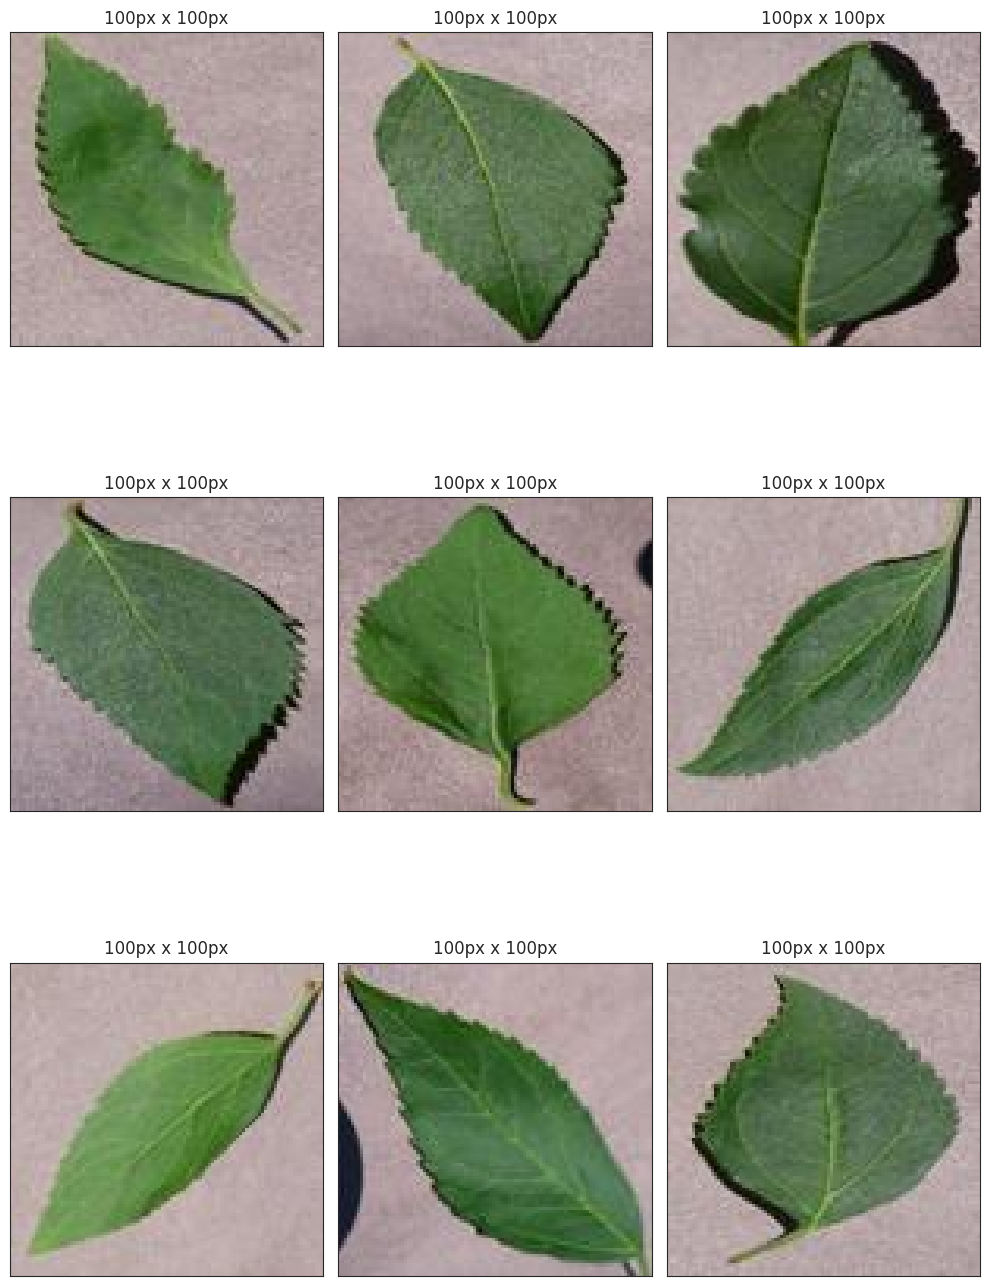



powdery_mildew


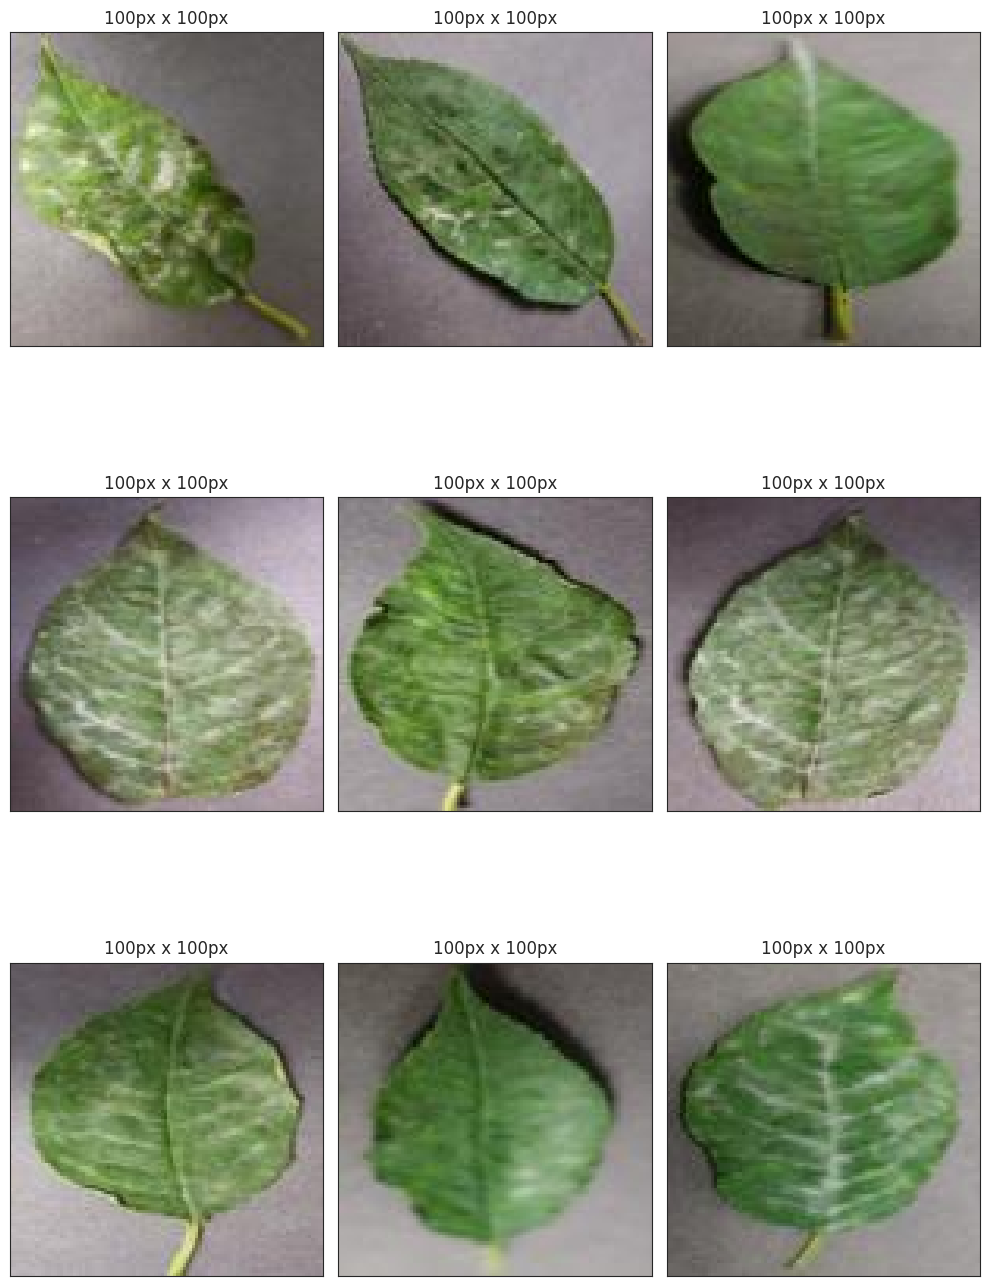

In [9]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")